# Customer Cuhrn Data Analysis

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')

In [2]:
user = 'root'
password = '7003890541'
host = 'localhost'
port = '3306'
database = 'churn_final_project'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

In [3]:
def sql(query,engine = engine):
    return pd.read_sql(query,engine)

In [4]:
query = '''
        select * from data limit 5
    '''
sql(query)

,id,age,gender,tenure,frequency,calls,payment_delay,subscription,contract,spend,last_interaction,churn
0,2.0,30.0,female,39.0,14.0,5.0,18.0,standard,annual,932.0,17.0,1.0
1,3.0,65.0,female,49.0,1.0,10.0,8.0,basic,monthly,557.0,6.0,1.0
2,4.0,55.0,female,14.0,4.0,6.0,18.0,basic,quarterly,185.0,3.0,1.0
3,5.0,58.0,male,38.0,21.0,7.0,7.0,standard,monthly,396.0,29.0,1.0
4,6.0,23.0,male,32.0,20.0,5.0,8.0,basic,monthly,617.0,20.0,1.0


In [28]:
num_cols = ['age','tenure','frequency','payment_delay','spend','last_interaction']
cat_cols = ['gender','subscription','calls','contract','churn']
all_cols = num_cols+cat_cols

### Univariate Analysis - Numerical Columns

In [33]:
query = f'''
    select {",".join(num_cols)} from data; 
'''
num_values=sql(query=query)
num_values.head()

,age,tenure,frequency,payment_delay,spend,last_interaction
0,30.0,39.0,14.0,18.0,932.0,17.0
1,65.0,49.0,1.0,8.0,557.0,6.0
2,55.0,14.0,4.0,18.0,185.0,3.0
3,58.0,38.0,21.0,7.0,396.0,29.0
4,23.0,32.0,20.0,8.0,617.0,20.0


**Distribution of numerical columns using kdeplot**

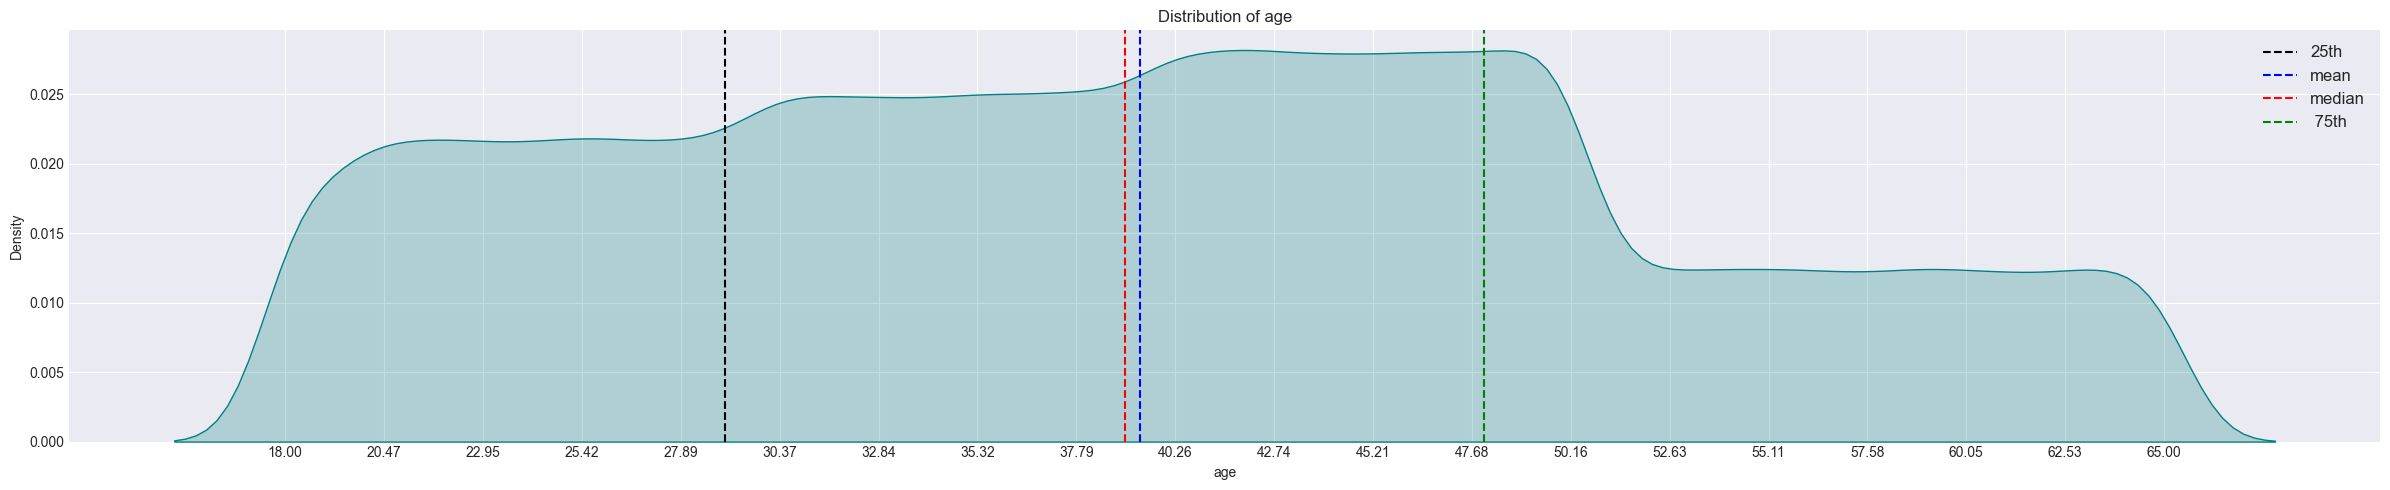

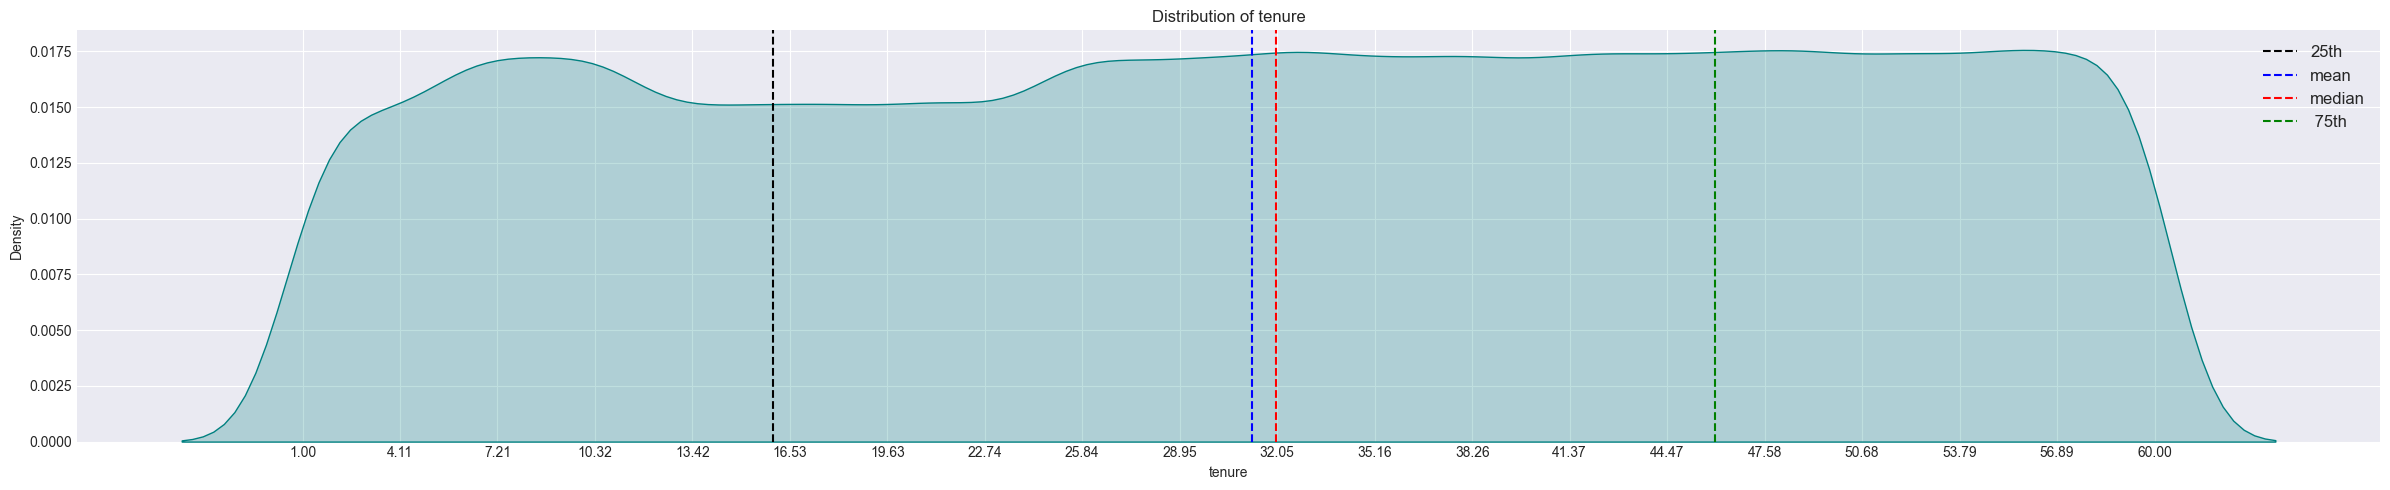

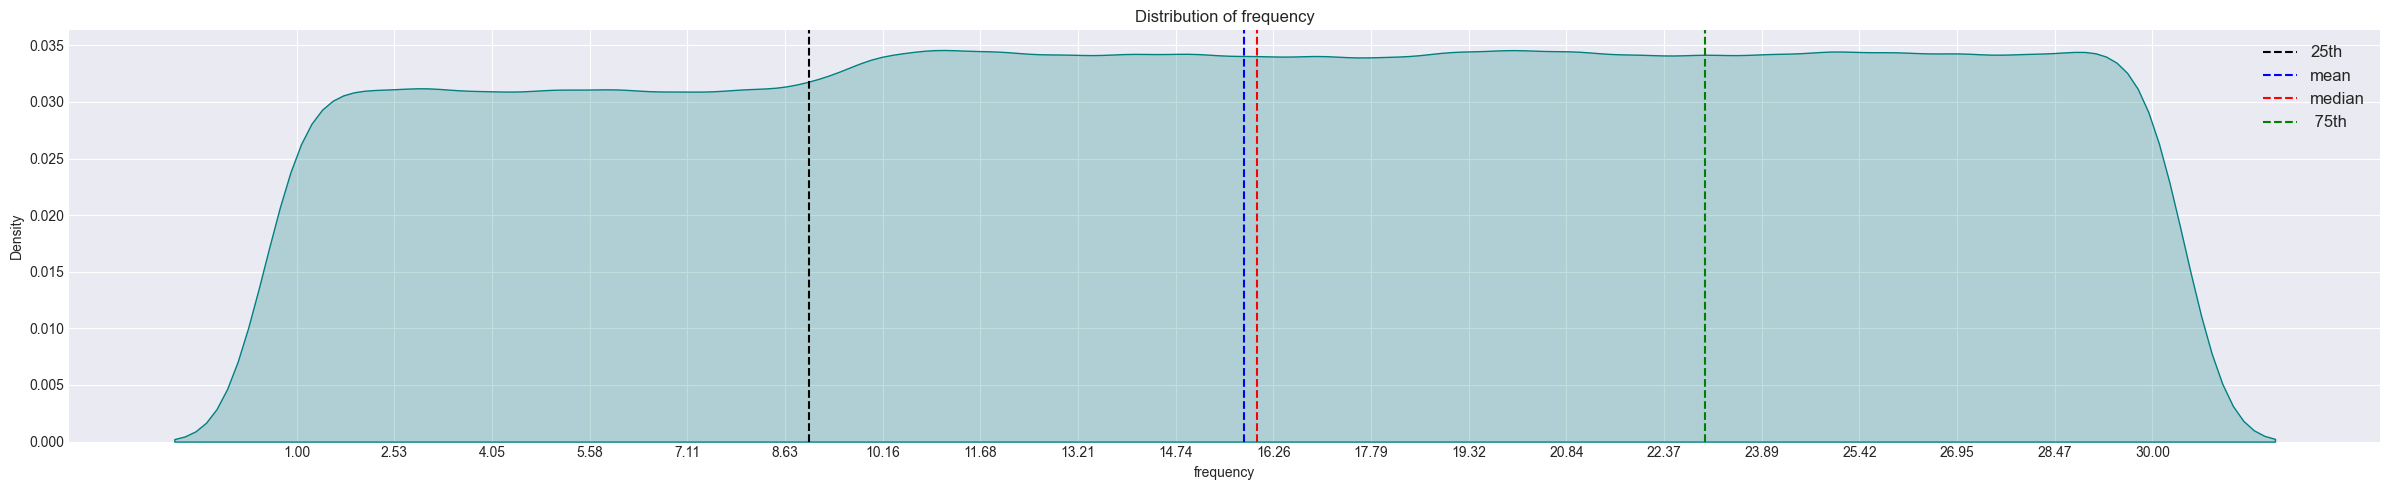

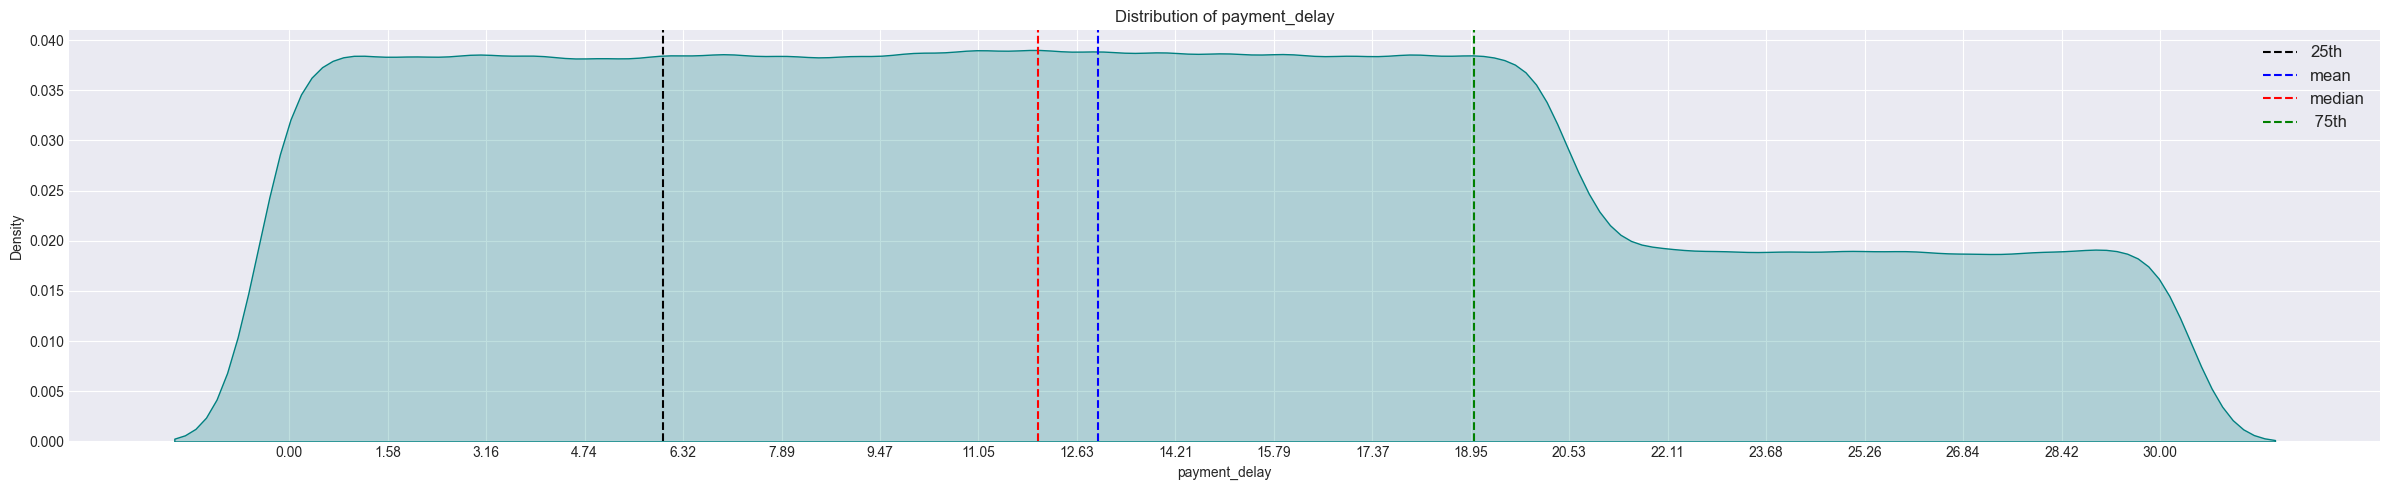

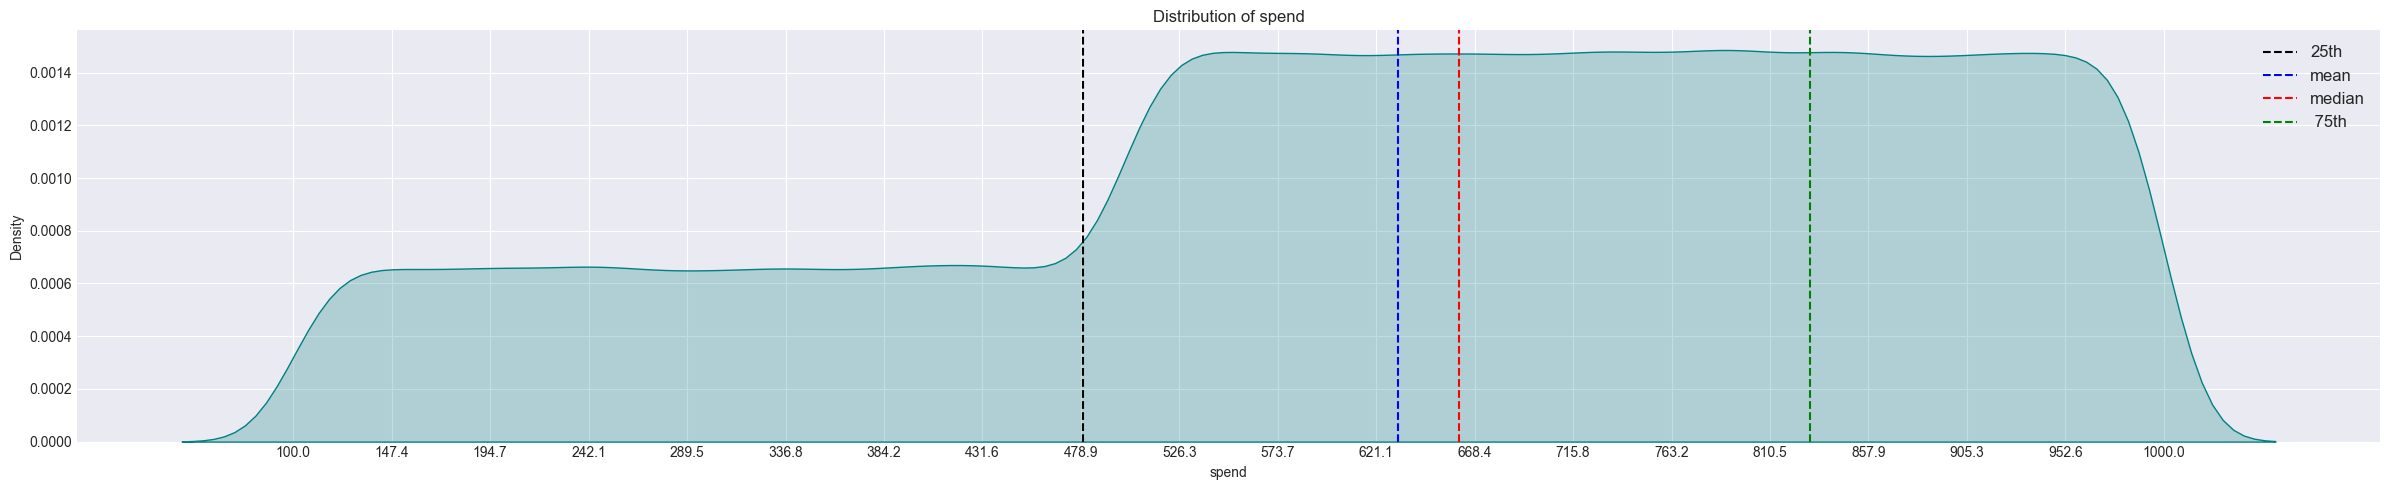

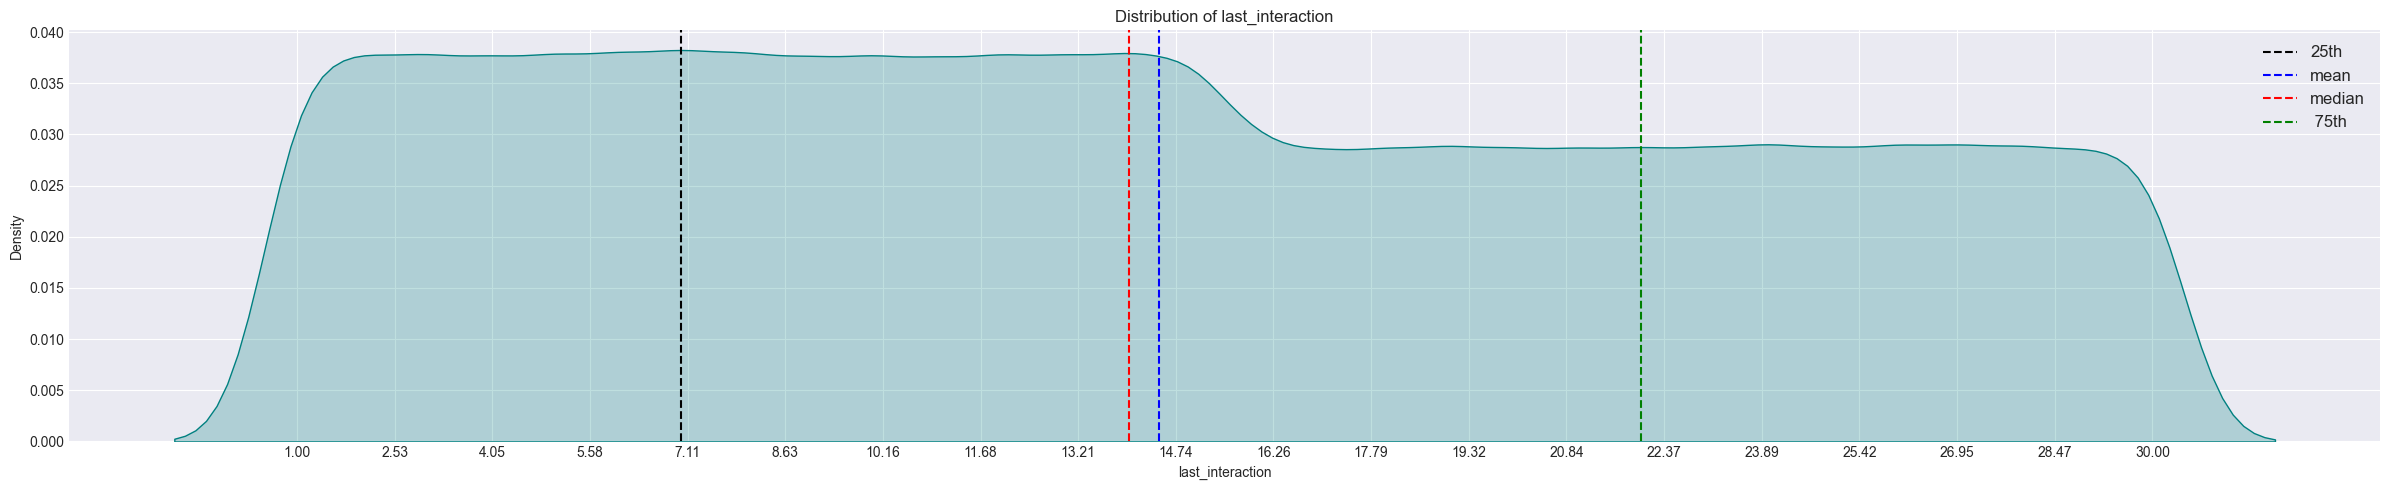

In [30]:
for col in num_values:
    mini = num_values[col].min()
    maxi = num_values[col].max()
    plt.figure(figsize=(24,5))
    sns.kdeplot(x=col,data=num_values,color= 'teal',fill=True)
    plt.axvline(num_values[col].quantile(.25),linestyle ='--',color = 'black',label='25th')
    plt.axvline(num_values[col].mean(),linestyle ='--',color = 'blue',label = 'mean')
    plt.axvline(num_values[col].median(),linestyle ='--',color = 'red',label = 'median')
    plt.axvline(num_values[col].quantile(.75),linestyle ='--',color = 'green',label =' 75th')
    plt.legend(fontsize = 12)
    plt.grid(alpha = 1)
    plt.xticks(np.linspace(mini,maxi,20))
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()
    

In [32]:
query = f'''
    select {",".join(cat_cols)} from data; 
'''
cat_values=sql(query=query)
cat_values.head()

,gender,subscription,calls,contract,churn
0,female,standard,5.0,annual,1.0
1,female,basic,10.0,monthly,1.0
2,female,basic,6.0,quarterly,1.0
3,male,standard,7.0,monthly,1.0
4,male,basic,5.0,monthly,1.0


In [64]:
df ={}
for col in cat_values:
    query = f'''
        select {col},
        count({col}) as count,
        round(100*(count({col})/(select count(*) from data)),2) as percentage
        from data
        group by {col}
    '''
    value_count = sql(query=query)
    df[col]=value_count

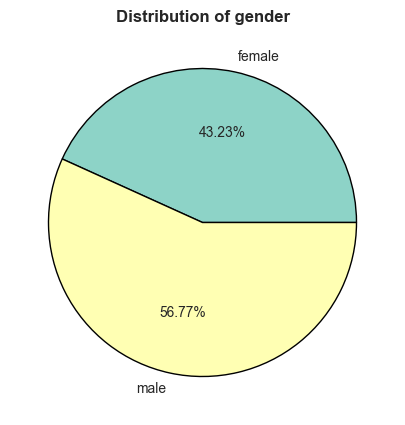

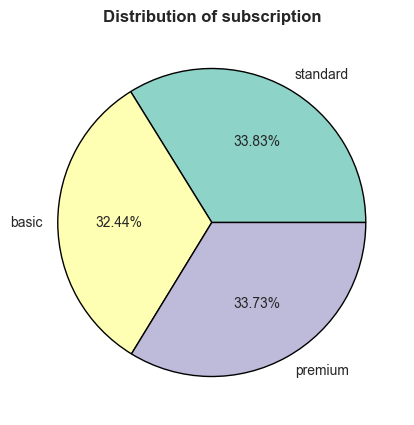

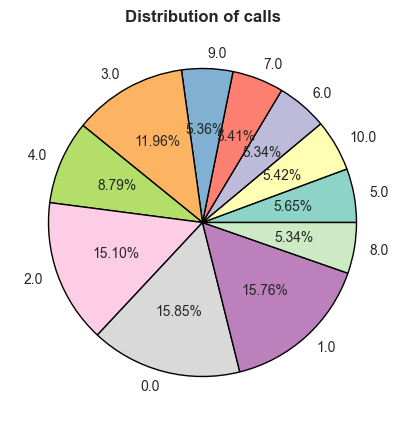

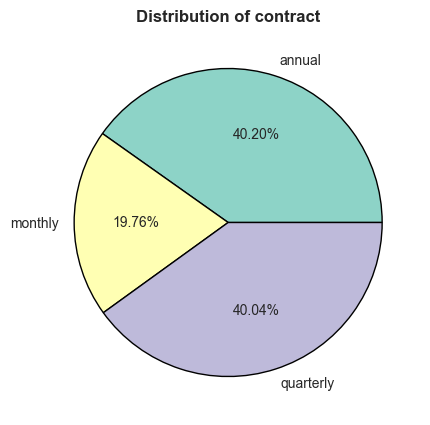

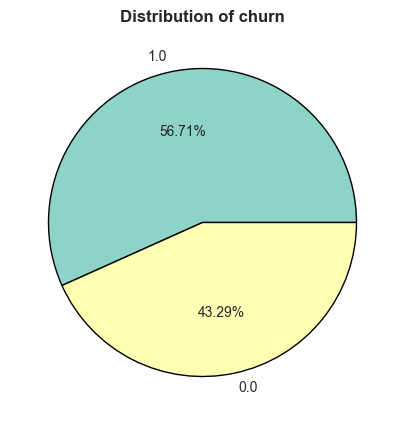

In [120]:
for col in cat_cols:
    dataset = df[col]
    plt.figure(figsize=(10,5))
    plt.pie(dataset['percentage'],labels=df[col].iloc[:,0].tolist(),
            autopct="%.2f%%",colors=plt.cm.Set3.colors,wedgeprops={'edgecolor':'black'})
    plt.title(f'Distribution of {col}',weight= 'bold')
    plt.show()

### Bivariate Analysis with Churn and Category

In [122]:
cat_cols

['gender', 'subscription', 'calls', 'contract', 'churn']

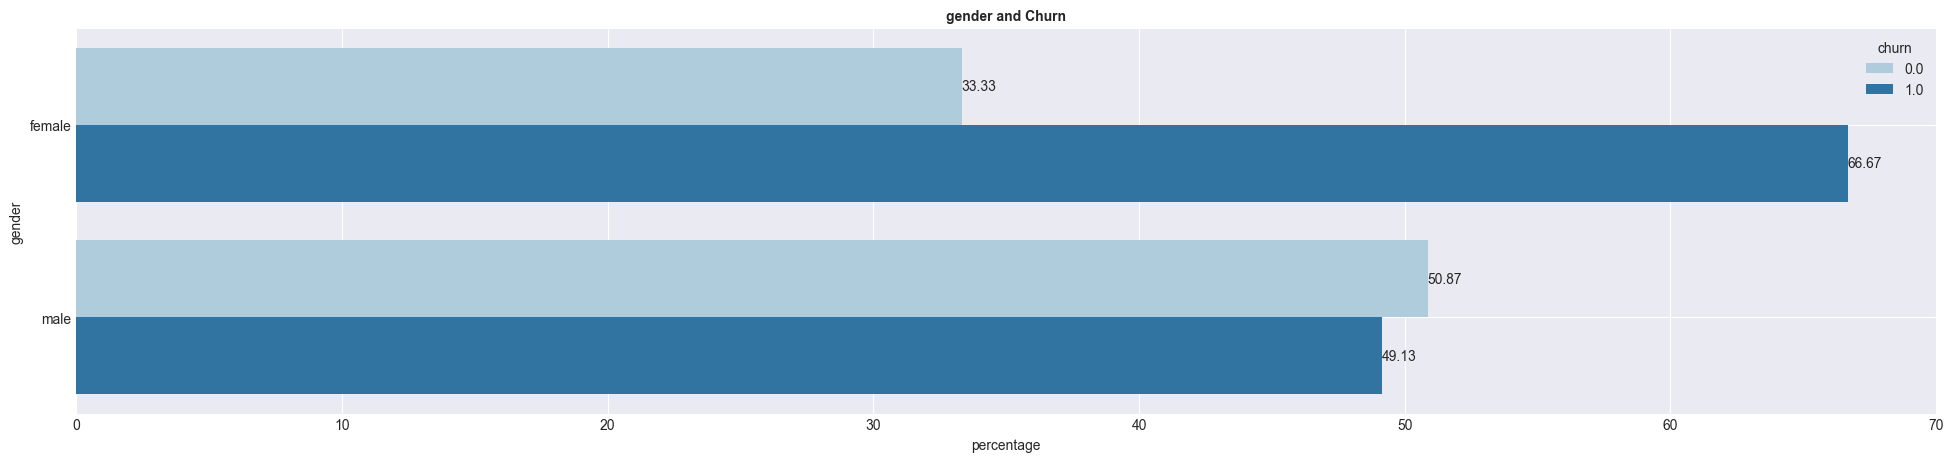

gender ->
__________________________________________________


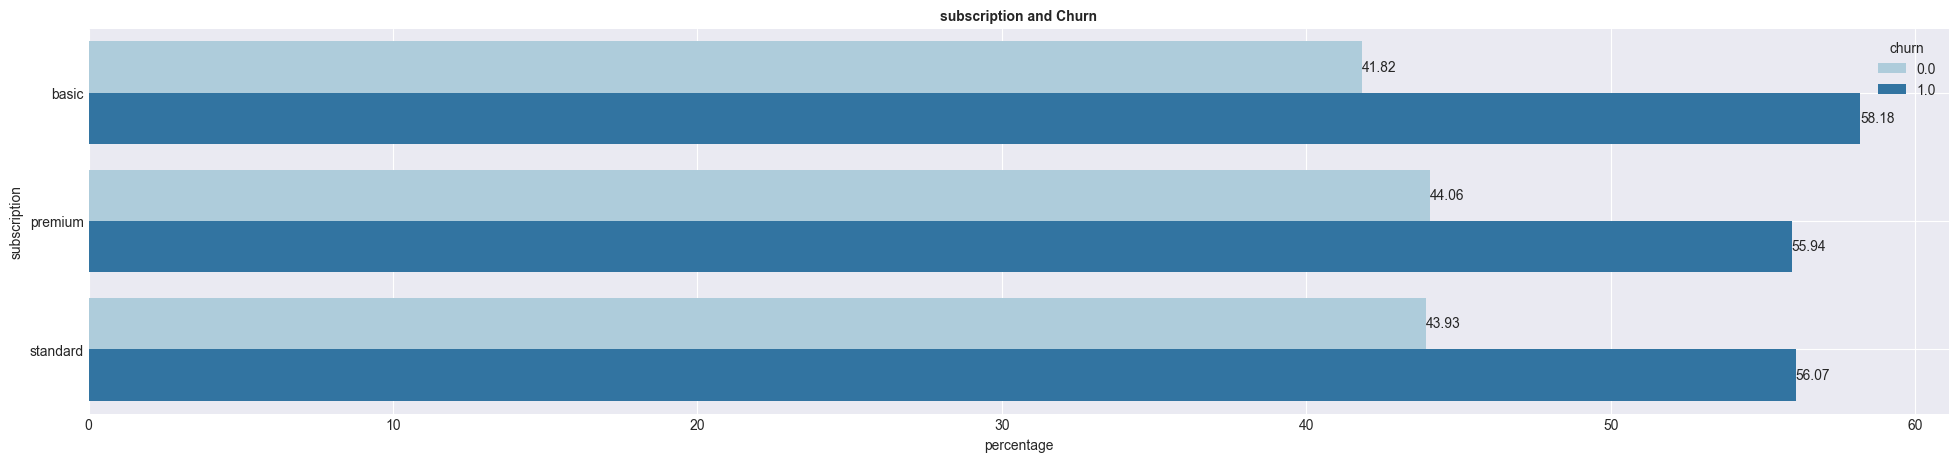

subscription ->
__________________________________________________


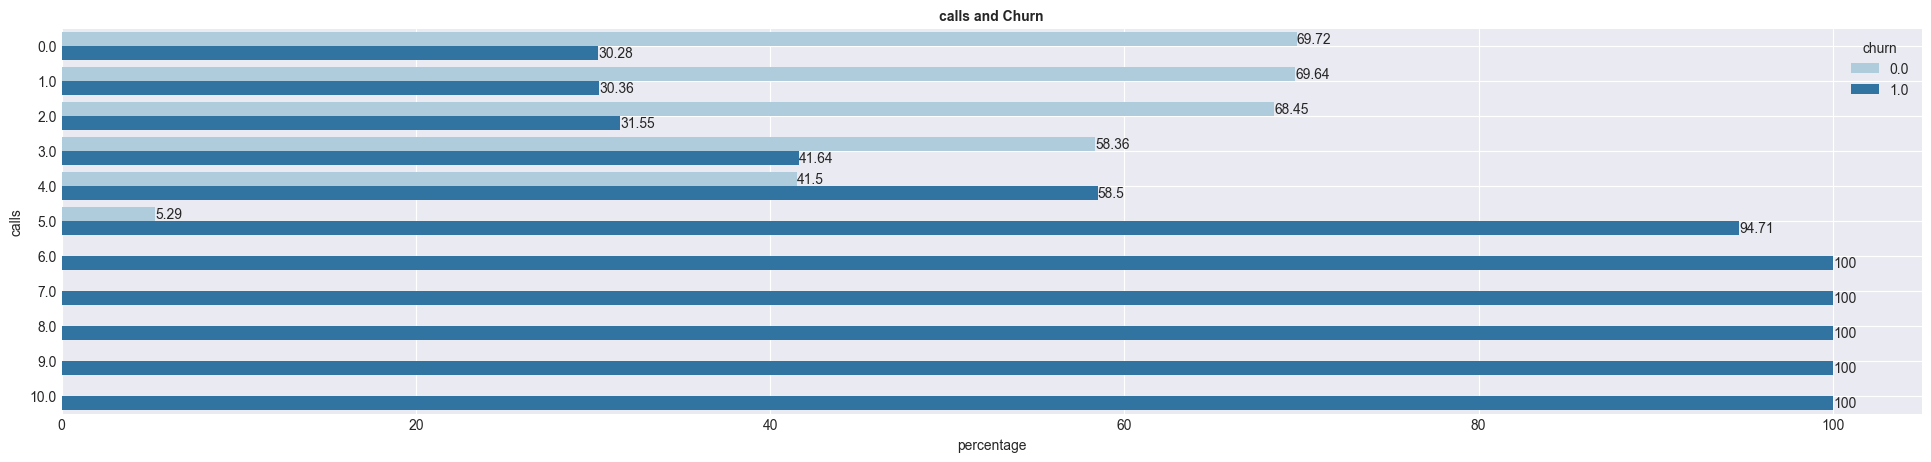

calls ->
__________________________________________________


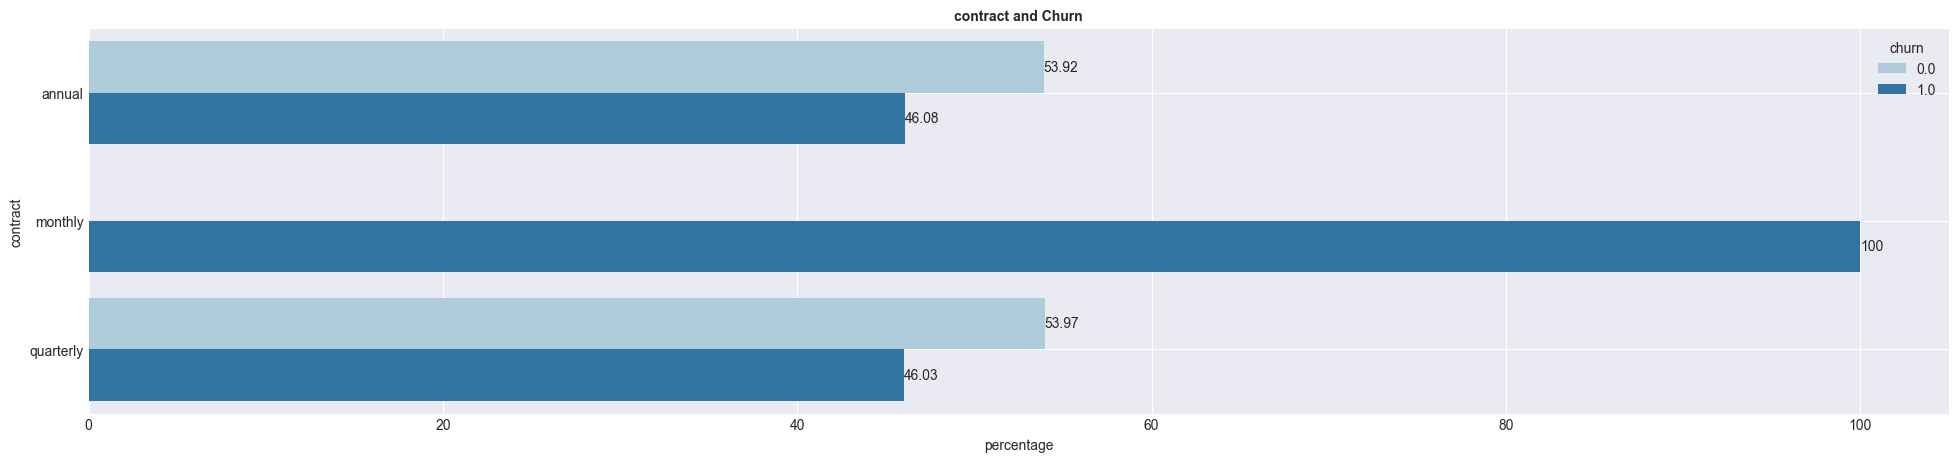

contract ->
__________________________________________________


In [161]:
for col in cat_cols[:-1]:
    query = f'''
            select 
        {col},
        churn,
        round(
            100 * count(*) /
            sum(count(*)) over (partition by {col})
        , 2) as percentage
    from data
    group by {col}, churn
    order by {col}, churn;
        '''
    val = sql(query=query)
    plt.figure(figsize=(24,5))
    ax=sns.barplot(y=col,hue='churn',x='percentage',data=val,palette='Paired',orient='h')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'{col} and Churn',fontsize=10,weight = 'bold')
    plt.grid(alpha = 1)
    plt.show()
    print(f'{col} ->')
    print("_"*50)

### Bivariate Analysis with Churn and Numerical

In [162]:
num_cols

['age', 'tenure', 'frequency', 'payment_delay', 'spend', 'last_interaction']

In [178]:
df = {}
for col in num_cols:
    query = f'''
        select churn, round(avg({col}),2) as average_{col} from data
        group by churn;
    '''
    val = sql(query=query)
    df[col] = val


In [179]:
for key,value in df.items():
    print(value)
    print("-"*50)

   churn  average_age
0    1.0        41.75
1    0.0        36.26
--------------------------------------------------
   churn  average_tenure
0    1.0           30.47
1    0.0           32.28
--------------------------------------------------
   churn  average_frequency
0    1.0              15.46
1    0.0              16.26
--------------------------------------------------
   churn  average_payment_delay
0    1.0                  15.22
1    0.0                  10.02
--------------------------------------------------
   churn  average_spend
0    1.0         541.29
1    0.0         749.95
--------------------------------------------------
   churn  average_last_interaction
0    1.0                     15.60
1    0.0                     13.01
--------------------------------------------------


### In- Depth Analysis with each column and churn

**Churn VS Age**

In [182]:
query = '''
        select churn,round(avg(age),2) as average_age from data
        group by churn;
    '''
avg_age_churn_category = sql(query=query)

In [183]:
avg_age_churn_category

,churn,average_age
0,1.0,41.75
1,0.0,36.26


In [184]:
query = '''
    select age from data
    where churn = 0
'''
non_churned_age = sql(query=query)

In [185]:
query = '''
    select age from data
    where churn = 1
'''
churned_age = sql(query=query)

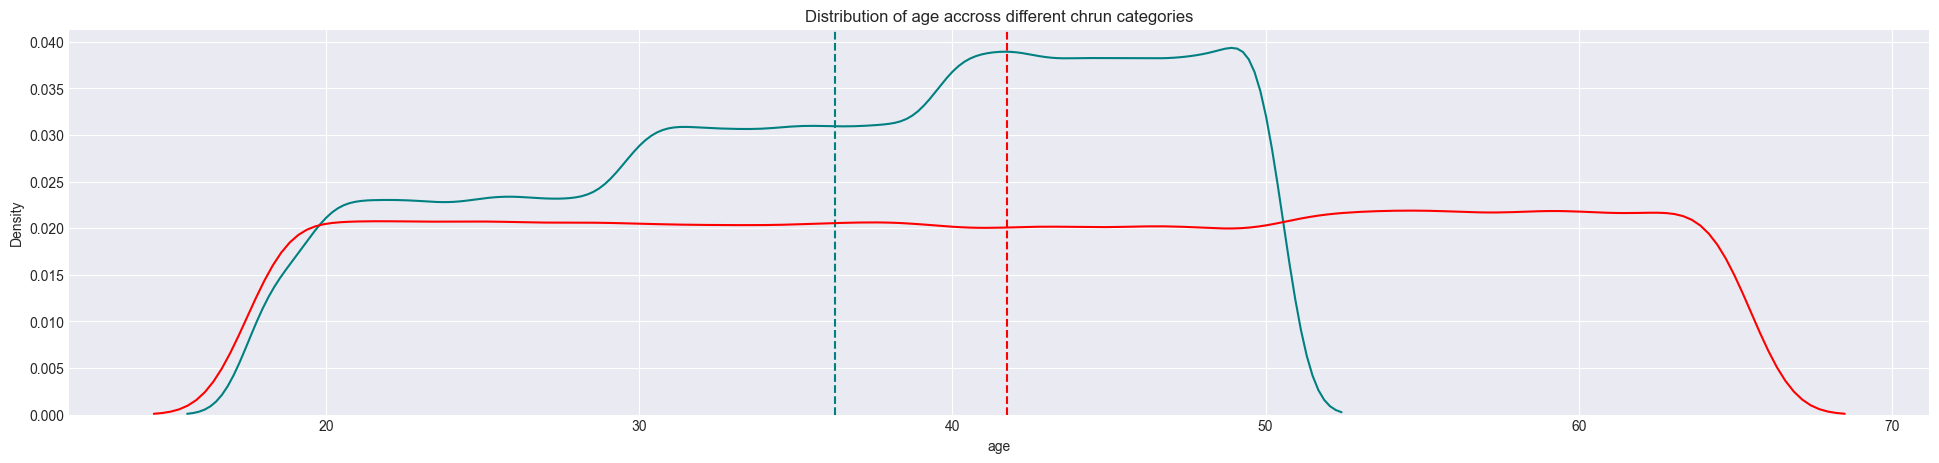

In [192]:
plt.figure(figsize=(24,5))
sns.kdeplot(x='age',data = non_churned_age,color='teal')
plt.axvline(np.mean(non_churned_age),linestyle = '--',color = 'teal')
sns.kdeplot(x='age',data = churned_age,color='red')
plt.axvline(np.mean(churned_age),linestyle = '--',color = 'red')
plt.grid(alpha = 1)
plt.title('Distribution of age accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()